# PPO with RNN Closing Price 

In [174]:
import numpy as np
import yfinance as yf
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import random

In [176]:
tickers = ["AAPL","MSFT","GOOGL","META","AMZN","TSLA","NVDA"]

data = {}
for t in tickers:
    df = yf.download(t, start="2020-01-01", end="2023-01-01")
    closes = df["Close"].values.astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    data[t] = {
        "dates": df.index,
        "raw":    closes,
        "norm":  (closes - mu) / sigma
    }

raw_prices = { t: data[t]["raw"]  for t in tickers }
normalized_prices = { t: data[t]["norm"] for t in tickers }

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### PPO for multiple stocks

In [298]:
state_dim   = 5  # window size 
action_dim  = 1   # how many features we have 
hidden_dim  = 32  # hidden layer size 
lr          = 3e-4
gamma       = 0.99
lam         = 0.95
clip_eps    = 0.2
epochs      = 400
batch_size  = 128
l2_lambda   = 1e-4

# build multi‐stock timeseries states
state_window = state_dim
states, next_states, rewards, dones = [], [], [], []

num_days = len(normalized_prices[tickers[0]]) - state_window - 1

for day in range(num_days):
    s_day, ns_day, r_day = [], [], []
    
    for t in tickers:
        arr = normalized_prices[t]
        
        s_day .append(arr[day:day+state_window])
        ns_day.append(arr[day+1:day+1+state_window])
        r_day .append((arr[day+state_window+1] - arr[day+state_window]).item())
        
        states     .append(s_day)
        next_states.append(ns_day)
        rewards    .append(r_day)
        dones      .append([0.0] * len(tickers))
    
# convert to tensors 
states      = torch.tensor(np.array(states),      dtype=torch.float32)
next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
rewards     = torch.tensor(np.array(rewards),     dtype=torch.float32)
dones       = torch.tensor(np.array(dones),       dtype=torch.float32)


class TunedRNNPolicy(nn.Module):
    def __init__(self, seq_len=state_dim, hidden_dim=hidden_dim):
        super().__init__()
        # 1) project each scalar → 32‐dim
        self.input_fc = nn.Linear(1, 32)
        # 2) two‐layer RNN
        self.rnn = nn.RNN(
            input_size=32,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            nonlinearity='tanh'
        )
        # 3) attention scorer: a single vector to dot‐product against each timestep
        self.attn_vec = nn.Parameter(torch.randn(hidden_dim))
        # 4) layer norm on the aggregated context
        self.norm = nn.LayerNorm(hidden_dim)
        # 5) separate heads + log_std
        self.fc_actor  = nn.Linear(hidden_dim, action_dim)
        self.fc_critic = nn.Linear(hidden_dim, 1)
        self.log_std   = nn.Parameter(torch.zeros(action_dim))
        self.seq_len   = seq_len

        # orthogonal init on RNN weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param, np.sqrt(2))
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x):
        """
        x: (B, seq_len) raw (already z-scored) input sequences
        returns:
          mean:  (B, action_dim)
          value: (B,)   critic value
        """
        B = x.size(0)
        # → (B, seq_len, 1)
        x = x.view(B, self.seq_len, 1)
        # project & nonlinearity → (B, seq_len, 32)
        x = F.relu(self.input_fc(x))
        # run RNN → (B, seq_len, hidden_dim)
        h_seq, _ = self.rnn(x)

        # compute raw attention scores: (B, seq_len)
        # h_seq @ attn_vec  => (B, seq_len)
        scores = torch.matmul(h_seq, self.attn_vec)
        weights = F.softmax(scores, dim=1).unsqueeze(-1)  # (B, seq_len, 1)

        # weighted average → context vector (B, hidden_dim)
        context = (h_seq * weights).sum(dim=1)
        # normalize
        h = self.norm(context)

        # heads
        mean  = self.fc_actor(h)
        value = self.fc_critic(h).squeeze(-1)
        return mean, value
        
w1      = TunedRNNPolicy()          # entire network stored in w1
w2a     = 'actor'               # dummy placeholders (still passed around)
w2c     = 'critic'
log_std = w1.log_std            # reference to parameter inside model

optimizer = torch.optim.SGD(
    w1.parameters(), momentum = 0.9, lr=lr, weight_decay=l2_lambda
)

def mlp_forward(x, model, head_flag):
    mean, value = model(x)
    return mean if head_flag == 'actor' else value

def get_action(state, model, *_):
    mean, _ = model(state)
    std  = model.log_std.exp()
    dist = torch.distributions.Normal(mean, std)
    action   = dist.sample()
    log_prob = dist.log_prob(action).sum(-1)
    return action, log_prob


# --------------------------------------


# Collect trajectories (days × stocks) 
with torch.no_grad():
    all_actions   = []
    all_log_probs = []
    all_values    = []

    for day in range(len(states)):            # 1) loop over days
        for stock in range(states.size(1)):  # 2) inner loop over 5 stocks
            s = states[day, stock].view(1, -1)
            a, lp = get_action(s, w1, w2a, log_std)
            v     = mlp_forward(s, w1, w2c)

            all_actions  .append(a)
            all_log_probs.append(lp)
            all_values   .append(v)

    # bootstrap final values for each stock
    for stock in range(next_states.size(1)):
        s_final = next_states[-1, stock].view(1, -1)
        all_values.append(mlp_forward(s_final, w1, w2c))

# reshape into tensors
actions   = torch.cat(all_actions).view(len(states), -1, action_dim)
log_probs = torch.stack(all_log_probs).view(len(states), -1)
values    = torch.stack(all_values).view(len(states)+1, states.size(1))

# GAE calculation
advantages = torch.zeros_like(rewards)
for stock in range(states.size(1)):
    last_adv = 0
    for t in reversed(range(len(states))):
        delta    = rewards[t,stock] \
                   + gamma * values[t+1,stock] * (1 - dones[t,stock]) \
                   - values[t,stock]
        last_adv = delta + gamma * lam * (1 - dones[t,stock]) * last_adv
        advantages[t,stock] = last_adv
returns = advantages + values[:-1]

# flatten transitions for PPO
flat_states  = states.view(-1, state_dim)
flat_actions = actions.view(-1, action_dim)
flat_lp_old  = log_probs.view(-1)
flat_ret     = returns.view(-1)
flat_adv     = advantages.view(-1)

# compute number of mini‑batches per epoch
n_trans   = flat_states.size(0)

n_batches = math.ceil(n_trans / batch_size)

actor_loss_hist = []
logprob_hist = []

# PPO training
for epoch in range(epochs):
    perm = torch.randperm(n_trans)
    epoch_actor_loss  = 0.0
    epoch_critic_loss = 0.0
    epoch_reward      = 0.0
    
    for batch_idx, start in enumerate(range(0, n_trans, batch_size), start=1):
        idx          = perm[start:start+batch_size]
        state_batch  = flat_states[idx]
        action_batch = flat_actions[idx].unsqueeze(1)
        old_logps_b  = flat_lp_old[idx].detach()
        return_batch = flat_ret[idx].detach()
        adv_batch    = flat_adv[idx].detach()

        # actor
        mean     = mlp_forward(state_batch, w1, w2a)
        std      = log_std.exp()
        dist     = torch.distributions.Normal(mean, std)
        new_lps  = dist.log_prob(action_batch).sum(axis=-1)

        ratio    = (new_lps - old_logps_b).exp()
        clipped  = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
        actor_loss = -torch.min(ratio * adv_batch, clipped).mean()

        # critic
        value_pred  = mlp_forward(state_batch, w1, w2c).squeeze(-1)
        critic_loss = F.mse_loss(value_pred, return_batch)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_actor_loss  += actor_loss.item()
        epoch_critic_loss += critic_loss.item()
        epoch_reward      += return_batch.mean().item()


        # per‑batch print
        print(f"  Epoch {epoch+1}, Batch {batch_idx}/{n_batches} → Batch Loss: {loss.item():.4f}")

    actor_loss_hist .append(epoch_actor_loss  / n_batches)
    critic_loss_hist.append(epoch_critic_loss / n_batches)
    reward_hist     .append(epoch_reward      / n_batches)   
    
    with torch.no_grad():
        mean_now = mlp_forward(flat_states, w1, w2a)
        std_now = log_std.exp()
        dist_now = torch.distributions.Normal(mean_now, std_now)
        new_logprobs = dist_now.log_prob(flat_actions).sum(-1)
        avg_logprob = new_logprobs.mean().item()
        logprob_hist.append(avg_logprob)
    


    print(f"*** Finished Epoch {epoch+1}/{epochs}: last batch loss {loss.item():.4f} ***")



  Epoch 1, Batch 1/288 → Batch Loss: 0.5593
  Epoch 1, Batch 2/288 → Batch Loss: 0.6543
  Epoch 1, Batch 3/288 → Batch Loss: 0.2169
  Epoch 1, Batch 4/288 → Batch Loss: 0.2701
  Epoch 1, Batch 5/288 → Batch Loss: 0.2472
  Epoch 1, Batch 6/288 → Batch Loss: 0.2497
  Epoch 1, Batch 7/288 → Batch Loss: 0.4194
  Epoch 1, Batch 8/288 → Batch Loss: 0.4647
  Epoch 1, Batch 9/288 → Batch Loss: 0.4611
  Epoch 1, Batch 10/288 → Batch Loss: 0.4686
  Epoch 1, Batch 11/288 → Batch Loss: 0.5823
  Epoch 1, Batch 12/288 → Batch Loss: 1.5521
  Epoch 1, Batch 13/288 → Batch Loss: 1.1782
  Epoch 1, Batch 14/288 → Batch Loss: 0.4241
  Epoch 1, Batch 15/288 → Batch Loss: 0.2620
  Epoch 1, Batch 16/288 → Batch Loss: 0.3314
  Epoch 1, Batch 17/288 → Batch Loss: 0.7080
  Epoch 1, Batch 18/288 → Batch Loss: 0.4331
  Epoch 1, Batch 19/288 → Batch Loss: 0.3005
  Epoch 1, Batch 20/288 → Batch Loss: 0.3147
  Epoch 1, Batch 21/288 → Batch Loss: 19.8814
  Epoch 1, Batch 22/288 → Batch Loss: 0.4486
  Epoch 1, Batch 2

In [290]:
#torch.save(w1.state_dict(), "model_RNN_CP_5.pth")
#torch.save(model, "model_RNN_CP_5.pth")
torch.save(model.state_dict(), "model_RNN_CP_5.pth")


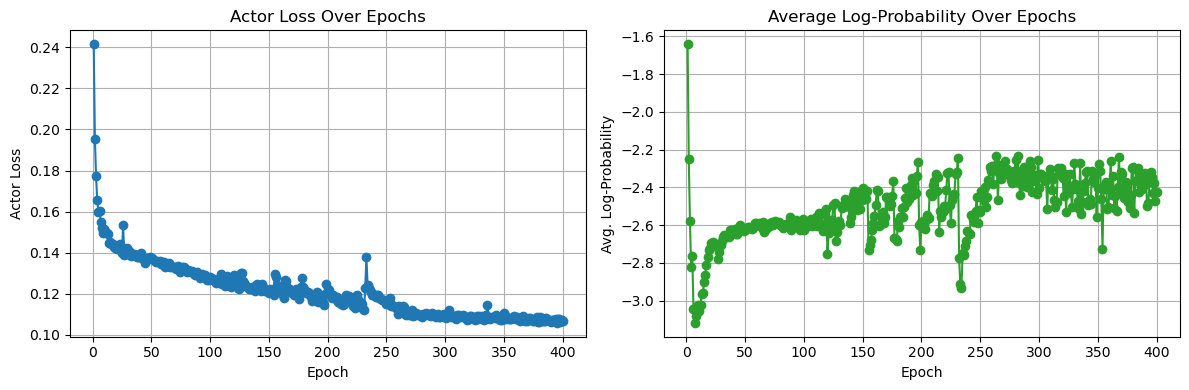

In [299]:
# Plot results after training
epochs_range = list(range(1, len(actor_loss_hist)+1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# 5.3.1 Actor Loss Over Epochs
ax1.plot(epochs_range, actor_loss_hist, marker='o')
ax1.set_title("Actor Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Actor Loss")
ax1.grid(True)

# 5.3.3 Log-Probability of Actions
ax2.plot(epochs_range, logprob_hist, marker='o', color='tab:green')
ax2.set_title("Average Log-Probability Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg. Log-Probability")
ax2.grid(True)

plt.tight_layout()
plt.savefig("RNN_actor_loss_and_logprob2.png", dpi=300)
plt.show()


### Trading Environment 

In [280]:
class MultiStockEnvironment:
    def __init__(self, raw_prices, window_size, initial_cash=10000):
        self.raw_prices   = raw_prices
        self.window_size  = window_size
        self.initial_cash = float(initial_cash)
        self.tickers      = list(raw_prices.keys())
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.initial_cash
        self.holdings = {t: 0.0 for t in self.tickers}
        self.portfolio_values = [self.initial_cash]
        self.done = False

        return {
            t: self.raw_prices[t][0:self.window_size]
            for t in self.tickers
        }

    def step(self, actions):
        # Liquidate negatives
        freed_cash = 0.0
        for t in self.tickers:
            if actions[t] < 0 and self.holdings[t] > 0:
                price = self.raw_prices[t][self.t + self.window_size].item()
                freed_cash += self.holdings[t] * price
                self.holdings[t] = 0.0
        self.cash += freed_cash

        # Allocate positives
        pos_actions = {t: actions[t] for t in self.tickers if actions[t] > 0}
        total_pos   = sum(pos_actions.values())
        if total_pos > 0 and self.cash > 0:
            for t, a in pos_actions.items():
                weight = a / total_pos
                price = self.raw_prices[t][self.t + self.window_size].item()
                buy_amount = self.cash * weight
                self.holdings[t] += buy_amount / price
            self.cash = 0.0

        # Compute portfolio value
        pv = self.cash
        for t in self.tickers:
            price = self.raw_prices[t][self.t + self.window_size].item()
            pv += self.holdings[t] * price
        self.portfolio_values.append(pv)

        # Advance time
        self.t += 1
        if self.t + self.window_size >= len(next(iter(self.raw_prices.values()))):
            self.done = True

        # Next state
        next_states = None
        if not self.done:
            next_states = {
                t: self.raw_prices[t][self.t : self.t + self.window_size]
                for t in self.tickers
            }

        return next_states, pv, self.done, {}


### buy and hold

In [283]:
class BuyAndHoldEnvironment:
    def __init__(self, raw_prices, initial_cash=10000):
        self.raw_prices = raw_prices
        self.initial_cash = initial_cash
        self.portfolio_values = []

    def run(self, start_index=10):
        # stack into shape (T,5)
        prices = np.stack([self.raw_prices[t] for t in tickers], axis=1)
        # equal allocation
        alloc = self.initial_cash / len(tickers)
        init_p = prices[start_index]            # [5,]
        shares = alloc / init_p                 # [5,]
        # build PV curve
        for p in prices[start_index+1:]:
            self.portfolio_values.append((shares * p).sum())

### Simulate Agent with the trained MLP once 

In [286]:
# Precompute price normalization stats 
mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price  = {t: raw_prices[t].std()  for t in tickers}

# Instantiate the environment 
env = MultiStockEnvironment(raw_prices, window_size=state_dim)
state_dict = env.reset()

day = 0
print("Starting multi-stock simulation...\n")

while not env.done:
    # Normalize state and sample actions
    actions = {}
    trades  = {}
    for t in tickers:
        win    = state_dict[t]  # price window of length state_dim
        norm_p = (win - mean_price[t]) / std_price[t]
        st     = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)

        a_tensor, _ = get_action(st, w1, w2a, log_std)
        a_val       = a_tensor.item()
        actions[t]  = a_val

        if   a_val > 0 and env.holdings[t] == 0:
            trades[t] = "BUY"
        elif a_val < 0 and env.holdings[t] > 0:
            trades[t] = "SELL"
        else:
            trades[t] = "HOLD"

    # Step the environment
    next_states, port_val, done, _ = env.step(actions)

    # Log values
    cash = float(env.cash)
    prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}
    held   = {t: float(env.holdings[t]) for t in tickers}

    # Print summary and per-ticker details
    print(f"Day {day}: Cash = {cash:.2f}, Portfolio = {port_val:.2f}")
    for t in tickers:
        print(f"  {t:>6s} | Price = {prices[t]:6.2f} | "
              f"Action = {actions[t]:6.4f} | Trade = {trades[t]:>4s} | "
              f"Held = {held[t]:6.4f}")
    print("-" * 60)

    # advance
    state_dict = next_states
    day += 1

print(f"\nDone. Final portfolio value: {env.portfolio_values[-1]:.2f}")


Starting multi-stock simulation...

Day 0: Cash = 0.00, Portfolio = 10000.00
    AAPL | Price =  74.96 | Action = -0.0787 | Trade = HOLD | Held = 0.0000
    MSFT | Price = 154.73 | Action = -0.0058 | Trade = HOLD | Held = 0.0000
   GOOGL | Price =  70.65 | Action = -1.0806 | Trade = HOLD | Held = 0.0000
    META | Price = 217.28 | Action = -0.0798 | Trade = HOLD | Held = 0.0000
    AMZN | Price =  95.05 | Action = -0.6623 | Trade = HOLD | Held = 0.0000
    TSLA | Price =  32.09 | Action = 1.4625 | Trade =  BUY | Held = 311.6300
    NVDA | Price =   6.05 | Action = -0.4461 | Trade = HOLD | Held = 0.0000
------------------------------------------------------------
Day 1: Cash = 0.00, Portfolio = 9933.73
    AAPL | Price =  75.13 | Action = 0.1201 | Trade =  BUY | Held = 0.0000
    MSFT | Price = 154.01 | Action = 0.8164 | Trade =  BUY | Held = 0.0000
   GOOGL | Price =  71.11 | Action = 0.1311 | Trade =  BUY | Held = 0.0000
    META | Price = 217.04 | Action = -2.3579 | Trade = HOLD | He

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_4814/1505298929.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}


Day 42: Cash = 0.00, Portfolio = 9562.77
    AAPL | Price =  66.84 | Action = -0.1469 | Trade = SELL | Held = 0.0000
    MSFT | Price = 147.05 | Action = -0.3926 | Trade = HOLD | Held = 0.0000
   GOOGL | Price =  60.26 | Action = -0.5045 | Trade = HOLD | Held = 0.0000
    META | Price = 169.44 | Action = -0.1398 | Trade = HOLD | Held = 0.0000
    AMZN | Price =  91.04 | Action = 0.4513 | Trade =  BUY | Held = 105.0358
    TSLA | Price =  42.28 | Action = -0.3589 | Trade = HOLD | Held = 0.0000
    NVDA | Price =   6.14 | Action = -0.3989 | Trade = SELL | Held = 0.0000
------------------------------------------------------------
Day 43: Cash = 0.00, Portfolio = 8805.20
    AAPL | Price =  60.24 | Action = -0.7467 | Trade = HOLD | Held = 0.0000
    MSFT | Price = 133.11 | Action = 0.6270 | Trade =  BUY | Held = 53.4096
   GOOGL | Price =  55.31 | Action = 0.1496 | Trade =  BUY | Held = 30.6637
    META | Price = 153.75 | Action = -0.2395 | Trade = HOLD | Held = 0.0000
    AMZN | Price =  

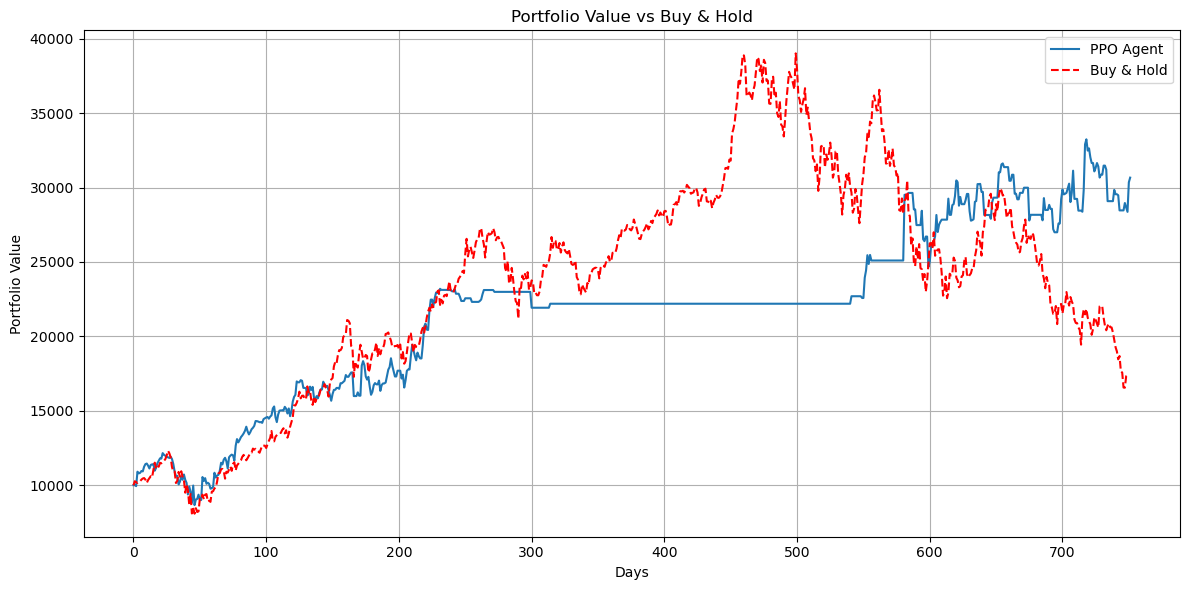


Final Results:
PPO final portfolio:       30663.47
Buy & Hold final portfolio:17379.21


In [288]:
bh_env = BuyAndHoldEnvironment(raw_prices)
bh_env.run(start_index=state_dim)

# 1) Plot PPO vs Buy & Hold
plt.figure(figsize=(12, 6))
plt.plot(env.portfolio_values, label='PPO Agent')
plt.plot(bh_env.portfolio_values, 'r--', label='Buy & Hold')
plt.title('Portfolio Value vs Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Final values
print("\nFinal Results:")
print(f"PPO final portfolio:       {env.portfolio_values[-1]:.2f}")
print(f"Buy & Hold final portfolio:{bh_env.portfolio_values[-1]:.2f}")


### Run the Environment 50 times to get an average on how the MLP is performing

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_4814/4247669203.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("RNN_Closing

Running PPO RNN (Closing Price) agent simulations...

Run  1/200 → Final Portfolio Value: 9063.42
Run  2/200 → Final Portfolio Value: 9424.39
Run  3/200 → Final Portfolio Value: 7135.25
Run  4/200 → Final Portfolio Value: 12307.77
Run  5/200 → Final Portfolio Value: 5749.64
Run  6/200 → Final Portfolio Value: 17636.93
Run  7/200 → Final Portfolio Value: 8257.20
Run  8/200 → Final Portfolio Value: 9797.49
Run  9/200 → Final Portfolio Value: 4059.61
Run 10/200 → Final Portfolio Value: 7060.40
Run 11/200 → Final Portfolio Value: 10406.66
Run 12/200 → Final Portfolio Value: 4976.96
Run 13/200 → Final Portfolio Value: 13422.06
Run 14/200 → Final Portfolio Value: 6573.46
Run 15/200 → Final Portfolio Value: 4894.67
Run 16/200 → Final Portfolio Value: 5570.44
Run 17/200 → Final Portfolio Value: 7161.21
Run 18/200 → Final Portfolio Value: 6356.79
Run 19/200 → Final Portfolio Value: 6481.01
Run 20/200 → Final Portfolio Value: 11906.77
Run 21/200 → Final Portfolio Value: 7624.14
Run 22/200 → Fina

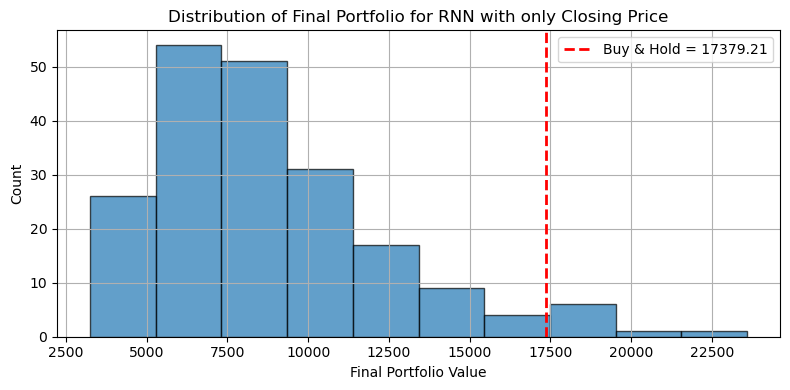

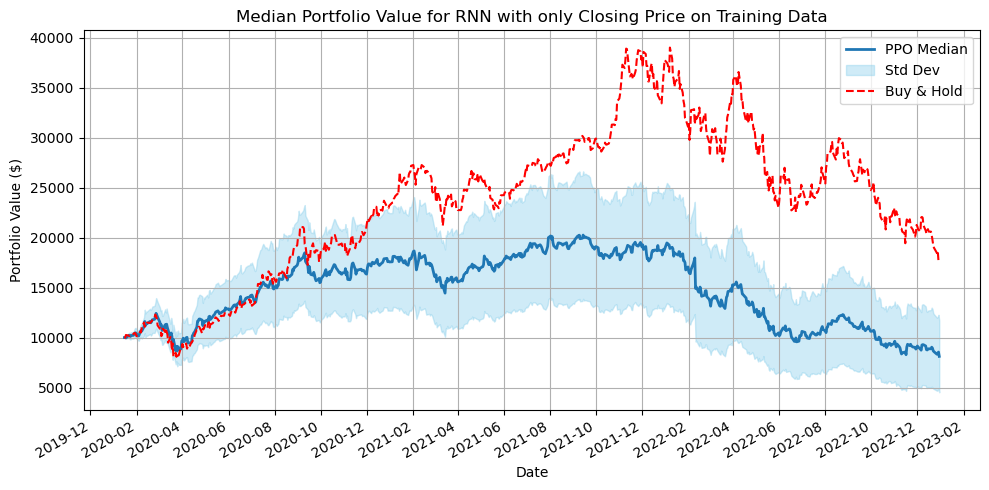

In [126]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import os

n_runs = 200
tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]

# === Load Buy & Hold ===
with open("buyhold_2020_2023.pkl", "rb") as f:
    bh_data = pickle.load(f)

bh_dates = pd.to_datetime(bh_data["dates"])
bh_curve = bh_data["curve"]
buy_hold_value = bh_curve[-1]
initial_cash = bh_curve[0]

mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price = {t: raw_prices[t].std() for t in tickers}

model = TunedRNNPolicy(seq_len=state_dim, hidden_dim=hidden_dim)
model.load_state_dict(torch.load("RNN_Closing/model_RNN_CP_3.pth"))
model.eval()

final_portfolios = []
ppo_trajectories = []

print("Running PPO RNN (Closing Price) agent simulations...\n")

for run in range(n_runs):
    env = MultiStockEnvironment(raw_prices, window_size=state_dim)
    state_dict = env.reset()
    done = False
    trajectory = [env.initial_cash]

    with torch.no_grad():
        while not done:
            actions = {}
            for t in tickers:
                win = state_dict[t].reshape(state_dim, 1)
                norm_win = (win - mean_price[t]) / std_price[t]
                st = torch.tensor(norm_win, dtype=torch.float32).unsqueeze(0)  # (1, 5, 1)
                a_val = get_action(st, model)[0].item()
                actions[t] = a_val

            state_dict, pv, done, _ = env.step(actions)
            trajectory.append(pv)

    final_value = trajectory[-1]
    final_portfolios.append(final_value)
    ppo_trajectories.append(trajectory)
    print(f"Run {run+1:2d}/{n_runs} → Final Portfolio Value: {final_value:.2f}")

# === Summary Stats ===
mean_pf = np.mean(final_portfolios)
std_pf = np.std(final_portfolios)
min_pf = np.min(final_portfolios)
max_pf = np.max(final_portfolios)
beats_bh = sum(p > buy_hold_value for p in final_portfolios)
beat_pct = beats_bh / n_runs * 100
loses_bh = n_runs - beats_bh

agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_portfolios]
bh_return = (buy_hold_value / initial_cash - 1) * 100

# === Print Summary ===
print(f"\nOver {n_runs} runs → mean final portfolio = {mean_pf:.2f} ± {std_pf:.2f}")
print(f"min = {min_pf:.2f}, max = {max_pf:.2f}")
print(f"Buy & Hold final portfolio = {buy_hold_value:.2f}")
print(f"\nAgent beat Buy & Hold  : {beats_bh}/{n_runs} runs ({beat_pct:.1f}%)")
print(f"Agent lost to Buy&Hold : {loses_bh}/{n_runs} runs ({100 - beat_pct:.1f}%)")
print(f"\nAverage agent return   : {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"Buy & Hold return      : {bh_return:.2f}%")

pd.DataFrame(final_portfolios, columns=["final_portfolio_value"]).to_csv("RNN_Closing/rnn_closing_train_final_portfolios.csv", index=False)

# Pad and save trajectories
max_len = max(len(pf) for pf in ppo_trajectories)
for i in range(n_runs):
    last_val = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last_val] * (max_len - len(ppo_trajectories[i]))
pd.DataFrame(ppo_trajectories).T.to_csv("RNN_Closing/rnn_closing_train_all_trajectories.csv", index=False)

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_portfolios, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(buy_hold_value, color='r', linestyle='--', linewidth=2,
            label=f'Buy & Hold = {buy_hold_value:.2f}')
plt.title("Distribution of Final Portfolio for RNN with only Closing Price")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("RNN_Closing/rnn_closing_histogram.png", dpi=600)
plt.show()

# === Median Curve ± Std ===
ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve = np.std(ppo_array, axis=0)
x_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]

min_len = min(len(x_dates), len(median_curve), len(bh_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("Median Portfolio Value for RNN with only Closing Price on Training Data")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("RNN_Closing/rnn_closing_median_std.png", dpi=600)
plt.show()


### test on unseen data 

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_4814/1567308440.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_RNN_C

Run 1/20 → Final Portfolio: 19032.78
Run 2/20 → Final Portfolio: 18181.16
Run 3/20 → Final Portfolio: 17370.41
Run 4/20 → Final Portfolio: 19365.36
Run 5/20 → Final Portfolio: 15264.49
Run 6/20 → Final Portfolio: 12413.82
Run 7/20 → Final Portfolio: 21487.73
Run 8/20 → Final Portfolio: 15014.76
Run 9/20 → Final Portfolio: 19720.07
Run 10/20 → Final Portfolio: 18026.69
Run 11/20 → Final Portfolio: 21591.73
Run 12/20 → Final Portfolio: 23778.49
Run 13/20 → Final Portfolio: 17981.13
Run 14/20 → Final Portfolio: 18790.90
Run 15/20 → Final Portfolio: 12825.19
Run 16/20 → Final Portfolio: 12097.06
Run 17/20 → Final Portfolio: 18356.59
Run 18/20 → Final Portfolio: 14127.39
Run 19/20 → Final Portfolio: 15781.46
Run 20/20 → Final Portfolio: 13635.08

=== RNN (Closing Price) Performance on Test Set ===
Runs: 20
→ Mean: 17242.11 ± 3179.90
→ Min: 12097.06, Max: 23778.49
→ Median: 18003.91
→ Buy & Hold Final: 20393.83
→ PPO beats Buy & Hold in 3/20 runs (15.0%)


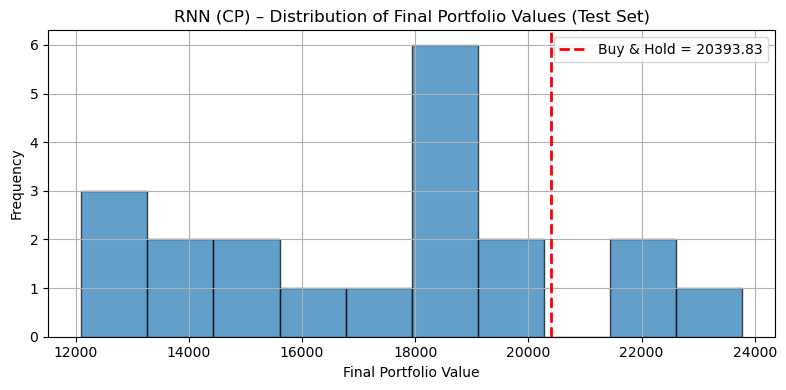

✓ Saved results to RNN_CP_Test_final_portfolios.csv


In [292]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy

# === Setup ===
tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
state_dim = 5
feat_dim = 1
initial_cash = 10000.0
n_runs = 20

# === Load Buy & Hold benchmark ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_final = bh_curve[-1]

# === Load model ===
model = TunedRNNPolicy(seq_len=state_dim)
model.load_state_dict(torch.load("model_RNN_CP_5.pth"))
model.eval()

# === Run PPO simulation ===
final_pf = []

for run in range(n_runs):
    env = MultiStockEnvironment(copy.deepcopy(raw_prices_test), window_size=state_dim, initial_cash=initial_cash)
    state_dict = env.reset()

    with torch.no_grad():
        while not env.done:
            actions = {}
            for t in tickers:
                win = state_dict[t]  # shape: (5, 6)
                st = torch.tensor(win, dtype=torch.float32).unsqueeze(0)  # shape: (1, 5, 6)
                a, _ = get_action(st, model)
                actions[t] = a.item()

            state_dict, _, _, _ = env.step(actions)

    final_pf.append(env.portfolio_values[-1])
    print(f"Run {run+1}/{n_runs} → Final Portfolio: {env.portfolio_values[-1]:.2f}")

# === Stats ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
median_pf = np.median(final_pf)
beats = sum(p > bh_final for p in final_pf)

print(f"\n=== RNN (Closing Price) Performance on Test Set ===")
print(f"Runs: {n_runs}")
print(f"→ Mean: {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Median: {median_pf:.2f}")
print(f"→ Buy & Hold Final: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beats/n_runs*100:.1f}%)")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("RNN (CP) – Distribution of Final Portfolio Values (Test Set)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("RNN_CP_Test_Hist.png", dpi=600)
plt.show()

# === Save CSV ===
#df_final = pd.DataFrame({"final_portfolio_value": final_pf})
#df_final.to_csv("RNN_CP_Test_final_portfolios.csv", index=False)
print("✓ Saved results to RNN_CP_Test_final_portfolios.csv")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy
import os

# === Setup ===
tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
state_dim = 5
feat_dim = 1
initial_cash = 10000.0
n_runs = 20

# === Load Buy & Hold benchmark ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_final = bh_curve[-1]

# === Load model ===
model = TunedRNNPolicy(seq_len=state_dim)
model.load_state_dict(torch.load("model_RNN_CP_5.pth"))
model.eval()

# === Run PPO simulation ===
final_pf = []
trajectories = []

for run in range(n_runs):
    env = MultiStockEnvironment(copy.deepcopy(raw_prices_test), window_size=state_dim, initial_cash=initial_cash)
    state_dict = env.reset()
    trajectory = [env.initial_cash]

    with torch.no_grad():
        while not env.done:
            actions = {}
            for t in tickers:
                win = state_dict[t]  # shape: (5, 6)
                st = torch.tensor(win, dtype=torch.float32).unsqueeze(0)  # shape: (1, 5, 6)
                a, _ = get_action(st, model)
                actions[t] = a.item()

            state_dict, port_val, done, _ = env.step(actions)
            trajectory.append(port_val)

    final_pf.append(trajectory[-1])
    trajectories.append(trajectory)
    print(f"Run {run+1}/{n_runs} → Final Portfolio: {trajectory[-1]:.2f}")

# === Pad trajectories to equal length ===
max_len = max(len(t) for t in trajectories)
for i in range(n_runs):
    last_val = trajectories[i][-1]
    trajectories[i] += [last_val] * (max_len - len(trajectories[i]))

# === Convert to array ===
trajectories_arr = np.array(trajectories)
median_curve = np.median(trajectories_arr, axis=0)
std_curve    = np.std(trajectories_arr, axis=0)

# === Stats ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
median_pf = np.median(final_pf)
beats = sum(p > bh_final for p in final_pf)

print(f"\n=== RNN (Closing Price) Performance on Test Set ===")
print(f"Runs: {n_runs}")
print(f"→ Mean: {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Median: {median_pf:.2f}")
print(f"→ Buy & Hold Final: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beats/n_runs*100:.1f}%)")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("RNN (CP) – Distribution of Final Portfolio Values (Test Set)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("RNN_CP_Test_Hist.png", dpi=600)
plt.show()

# === Median + Std Plot ===

# Trim bh_curve to match median_curve length
min_len = min(len(median_curve), len(bh_curve))
median_curve = median_curve[:min_len]
std_curve    = std_curve[:min_len]
bh_curve     = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(median_curve, label='PPO Median', linewidth=2)
plt.fill_between(range(min_len),
                 median_curve - std_curve,
                 median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(bh_curve, label='Buy & Hold', color='red', linestyle='--', linewidth=2)

plt.title("RNN (CP) – Median Portfolio Value Over Time (±1 Std Dev)")
plt.xlabel("Timesteps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("RNN_CP_Test_Median_Curve.png", dpi=600)
plt.show()

"""
# === Save CSVs ===
os.makedirs("RNN_CP_Test_Results", exist_ok=True)

# Save final portfolio values
df_final = pd.DataFrame({"final_portfolio_value": final_pf})
df_final.to_csv("RNN_CP_Test_Results/final_portfolios.csv", index=False)

# Save all PPO trajectories
df_traj = pd.DataFrame(trajectories_arr.T)  # transpose so time steps are rows
df_traj.to_csv("RNN_CP_Test_Results/all_trajectories.csv", index=False)

print("✓ Saved results to:")
print("  → RNN_CP_Test_Results/final_portfolios.csv")
print("  → RNN_CP_Test_Results/all_trajectories.csv")
print("  → RNN_CP_Test_Median_Curve.png")
print("  → RNN_CP_Test_Hist.png")
"""

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy
import os

# === Setup ===
tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
state_dim = 5
feat_dim = 6
initial_cash = 10000.0
n_runs = 20

# === Load Buy & Hold benchmark ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_final = bh_curve[-1]

# === Load model ===
model = TunedRNNPolicy(seq_len=state_dim)
model.load_state_dict(torch.load("model_RNN_CP_5.pth"))
model.eval()

# === Run PPO simulation ===
final_pf = []
trajectories = []

for run in range(n_runs):
    env = MultiStockEnvironment(copy.deepcopy(raw_prices_test), window_size=state_dim, initial_cash=initial_cash)
    state_dict = env.reset()
    trajectory = [env.initial_cash]

    with torch.no_grad():
        while not env.done:
            actions = {}
            for t in tickers:
                win = state_dict[t]  # shape: (5, 6)
                st = torch.tensor(win, dtype=torch.float32).unsqueeze(0)  # shape: (1, 5, 6)
                a, _ = get_action(st, model)
                actions[t] = a.item()

            state_dict, port_val, done, _ = env.step(actions)
            trajectory.append(port_val)

    final_pf.append(trajectory[-1])
    trajectories.append(trajectory)
    print(f"Run {run+1}/{n_runs} → Final Portfolio: {trajectory[-1]:.2f}")

# === Pad trajectories to equal length ===
max_len = max(len(t) for t in trajectories)
for i in range(n_runs):
    last_val = trajectories[i][-1]
    trajectories[i] += [last_val] * (max_len - len(trajectories[i]))

# === Convert to array ===
trajectories_arr = np.array(trajectories)
median_curve = np.median(trajectories_arr, axis=0)
std_curve    = np.std(trajectories_arr, axis=0)

# === Stats ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
median_pf = np.median(final_pf)
beats = sum(p > bh_final for p in final_pf)

print(f"\n=== RNN (Closing Price) Performance on Test Set ===")
print(f"Runs: {n_runs}")
print(f"→ Mean: {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Median: {median_pf:.2f}")
print(f"→ Buy & Hold Final: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beats/n_runs*100:.1f}%)")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("RNN (CP) – Distribution of Final Portfolio Values (Test Set)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("RNN_CP_Test_Hist.png", dpi=600)
plt.show()

# === Median + Std Plot ===

# Trim bh_curve to match median_curve length
min_len = min(len(median_curve), len(bh_curve))
median_curve = median_curve[:min_len]
std_curve    = std_curve[:min_len]
bh_curve     = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(median_curve, label='PPO Median', linewidth=2)
plt.fill_between(range(min_len),
                 median_curve - std_curve,
                 median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(bh_curve, label='Buy & Hold', color='red', linestyle='--', linewidth=2)

plt.title("RNN (CP) – Median Portfolio Value Over Time (Std Dev)")
plt.xlabel("Timesteps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("RNN_CP_Test_Median_Curve1.png", dpi=600)
plt.show()


"""
# Save final portfolio values
df_final = pd.DataFrame({"final_portfolio_value": final_pf})
df_final.to_csv("RNN_CP_Test_Results/final_portfolios1.csv", index=False)

# Save all PPO trajectories
df_traj = pd.DataFrame(trajectories_arr.T)  # transpose so time steps are rows
df_traj.to_csv("RNN_CP_Test_Results/all_trajectories1.csv", index=False)

print("✓ Saved results to:")
print("  → RNN_CP_Test_Results/final_portfolios.csv")
print("  → RNN_CP_Test_Results/all_trajectories.csv")
print("  → RNN_CP_Test_Median_Curve.png")
print("  → RNN_CP_Test_Hist.png")
"""